In [1]:
import urllib.request

import geopandas
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import pandas as pd
import planetary_computer
import pystac_client
import rioxarray
import xarray as xr
import odc.stac
import dask.distributed

In [2]:
from shapely import wkt

In [3]:
# https://boundingbox.klokantech.com/

region = wkt.loads(
    "POLYGON((-58.611677 -34.469254, -58.271327 -34.469254, -58.271327 -34.725584, -58.611677 -34.725584, -58.611677 -34.469254))"
)
bbox = region.bounds

In [4]:
start = pd.Timestamp("2020-01-01")
stop = pd.Timestamp("2020-03-01")

In [5]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/",
    modifier=planetary_computer.sign_inplace,
)

filter_query = {"eo:cloud_cover": {"lte": 20}}

query = catalog.search(
    collections=["sentinel-2-l2a"],
    datetime=[start, stop],
    limit=100,  # Consider making this configurable
    bbox=bbox,
    query=filter_query
)

items = list(query.items())

In [6]:
len(items)

6

In [7]:
items[0]

<Item id=S2A_MSIL2A_20200228T135111_R024_T21HUB_20200928T230315>

In [8]:
bands = ["red", "green", "blue"]

In [9]:
ds = odc.stac.load(items, bands=bands, chunks={}, intersects=region)

In [10]:
γ = 2.2

rgb = (
    ds.to_array(dim="band")
    .transpose("time", "band", "y", "x")
    .sel(band=["red", "green", "blue"])
)
rgb = rgb / rgb.max(dim=["band", "y", "x"])
rgb = (rgb ** (1 / γ)).clip(0, 1)
rgb

<xarray.DataArray (time: 6, band: 3, y: 2888, x: 3162)> Size: 657MB
dask.array<clip, shape=(6, 3, 2888, 3162), dtype=float32, chunksize=(1, 1, 2888, 3162), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 23kB 6.185e+06 6.185e+06 ... 6.156e+06 6.156e+06
  * x            (x) float64 25kB 3.52e+05 3.52e+05 ... 3.836e+05 3.836e+05
    spatial_ref  int32 4B 32721
  * time         (time) datetime64[ns] 48B 2020-01-04T13:51:09.024000 ... 202...
  * band         (band) object 24B 'red' 'green' 'blue'

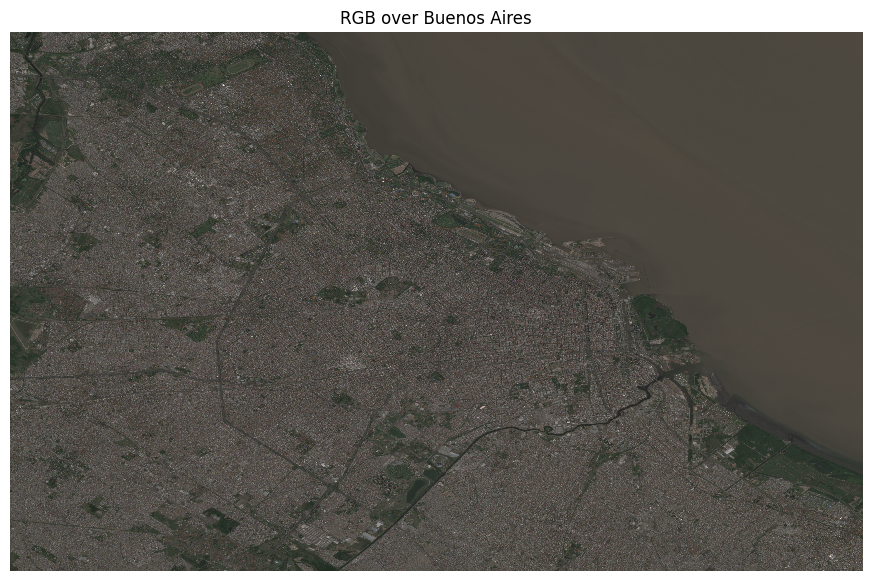

In [11]:
fig, ax = plt.subplots(figsize=(11,7))
rgb.isel(time=2).plot.imshow(rgb="band", add_labels=False, ax=ax)
plt.title('RGB over Buenos Aires')
ax.set_axis_off()
plt.show()

In [12]:
def compute_ndvi(ds, ndvi_bands, resolution=10):
    """
    Loads 'red' and 'nir' bands and computes NDVI.
    Assumes that odc.stac.load handles scale/offset factors from STAC metadata.

    Args:
        resolution (int): Spatial resolution for loading bands.

    Returns:
        xarray.DataArray: Calculated NDVI, or None if bands could not be loaded.
    """
    
    bands_dataset = ds.copy()
    # Ensure all bands are float and compute
    for band_name in ndvi_bands:
        if band_name in bands_dataset:
            bands_dataset[band_name] = bands_dataset[band_name].astype(float, copy=False).compute()

    if bands_dataset is None or not bands_dataset.data_vars:
        print("Could not load 'red' and 'nir' bands for NDVI calculation.")
        return None
    
    if "nir" not in bands_dataset:
        print("Error: 'nir' band not found in loaded dataset.")
        return None
    if "red" not in bands_dataset:
        print("Error: 'red' band not found in loaded dataset.")
        return None

    nir_band = bands_dataset["nir"]
    red_band = bands_dataset["red"]

    ndvi = (nir_band - red_band) / (nir_band + red_band)
    ndvi.name = "ndvi"

    return ndvi

In [13]:
ndvi_bands = ['red','nir']

In [14]:
ndvi = odc.stac.load(items, bands=ndvi_bands, chunks={}, groupby='solar_day', intersects=region)

In [15]:
ndvi = compute_ndvi(ndvi, ndvi_bands)

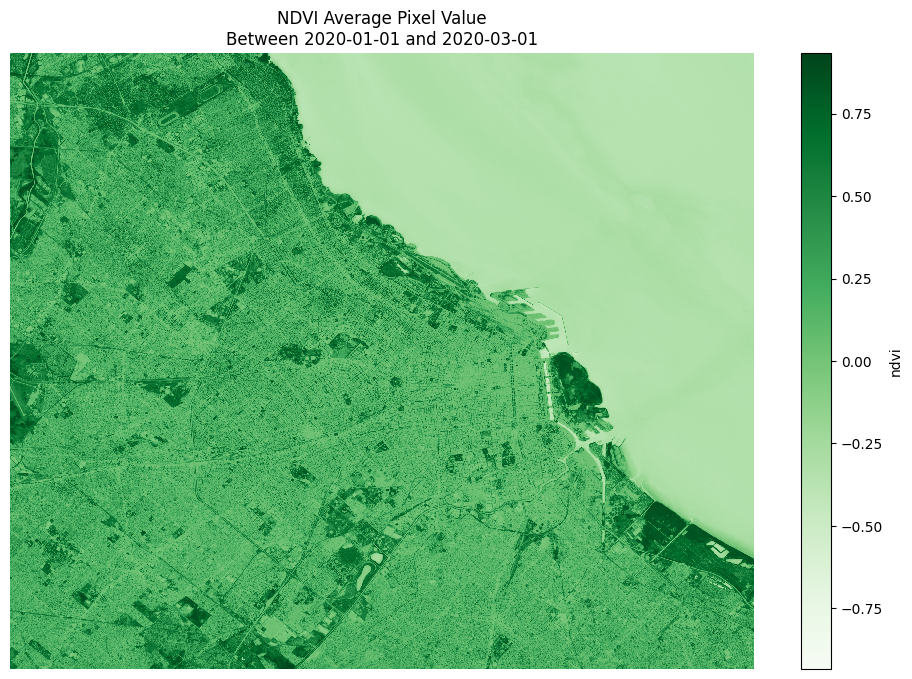

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))
ndvi.mean(dim='time').plot(cmap='Greens', ax = ax)
plt.title(f'NDVI Average Pixel Value\nBetween {start.strftime("%Y-%m-%d")} and {stop.strftime("%Y-%m-%d")}')
ax.set_axis_off()
plt.show()